In [34]:
# === Core Libraries ===
import os
import warnings

# === Data Manipulation ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning ===
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.exceptions import ConvergenceWarning

# === Suppress Convergence Warnings ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [35]:
# === Parameters ===

# --- File paths and data loading ---
data_path = "datasets_2023-2025_beta.parquet"

# --- Coins to exclude from modeling ---
exclude_files = [
    'DAIUSD_720.parquet', 'USDCUSD_720.parquet', 'USDTUSD_720.parquet',
    'USTUSD_720.parquet', 'AUDUSD_720.parquet', 'EURUSD_720.parquet',
    'GBPUSD_720.parquet', 'PAXGUSD_720.parquet'
]

# --- Modeling windows ---
train_period_days = 30          # Number of days in training window
pred_period_days = 7            # Number of days in test window
lookahead = 1                   # Return prediction horizon (in steps, not days)

# --- Strategy tuning ---
top_decile = 0.1                # % of top-ranked coins to long
bottom_decile = 0.1            # % of bottom-ranked coins to short

# --- Analysis output ---
top_k = 20                      # Number of top predictors to show in bar plots

In [36]:
"""
Title: Lasso and Ridge Regression Evaluation on Cryptocurrency Returns

Description:
This script performs a predictive evaluation of cryptocurrenczy log returns using 
Lasso and Ridge regression models. It trains the models on a specified historical 
window (`train_period_days`) and tests them on a future prediction horizon (`pred_period_days`), 
both configurable at the top of the script.

For each coin:
- Data is filtered and target returns are set as future log returns.
- Features are standardized using `StandardScaler`.
- Models (LassoCV and RidgeCV) are trained and evaluated.
- R² and MSE metrics are recorded for both models.
- A realized Sharpe ratio is computed using actual returns.
- A plot comparing true vs. predicted returns is saved for each coin.

The script outputs:
- A CSV (`lasso_ridge_results_[train]d_[test]d.csv`) summarizing performance metrics across coins.
- PNG plots for each coin stored in the `plots_lasso_ridge_[train]d_[test]d` folder.
- Log messages for any skipped or failed coins due to insufficient data or errors.

Make sure your data is stored in `datasets_2023-2025_beta.parquet` and contains fields:
'timestamp', 'log_return', 'filename', and valid predictive features.

Example usage:
Set `train_period_days = 30` and `pred_period_days = 7` to train on 1 month and test on 1 week.
"""

# === Load data ===
original_df = pd.read_parquet(data_path).sort_values("timestamp")
df = pd.read_parquet(data_path).sort_values(["filename", "timestamp"])

plot_folder = f"plots_lasso_ridge_{train_period_days}d_{pred_period_days}d"
results_csv = f"lasso_ridge_results_{train_period_days}d_{pred_period_days}d.csv"

results = []
lasso_models = {}  # Store trained Lasso models
ridge_models = {}  # Store trained Ridge models

train_seconds = train_period_days * 86400
pred_seconds = pred_period_days * 86400

for coin, coin_df in df.groupby("filename"):
    if coin in exclude_files:
        continue

    coin_df = coin_df.sort_values("timestamp")
    features = [col for col in coin_df.columns if col not in ['timestamp', 'return', 'log_return', 'filename']]
    coin_df = coin_df.dropna(subset=features + ['log_return'])
    coin_df['target'] = coin_df['log_return'].shift(-lookahead)
    coin_df = coin_df.dropna()

    if len(coin_df) < 100:
        continue

    start_ts = coin_df['timestamp'].min()
    train_end_ts = start_ts + train_seconds
    test_end_ts = train_end_ts + pred_seconds

    train_df = coin_df[(coin_df['timestamp'] >= start_ts) & (coin_df['timestamp'] < train_end_ts)]
    test_df = coin_df[(coin_df['timestamp'] >= train_end_ts) & (coin_df['timestamp'] < test_end_ts)]

    if len(train_df) < 50 or len(test_df) < 10:
        continue

    X_train, y_train = train_df[features], train_df["target"]
    X_test, y_test = test_df[features], test_df["target"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lasso = LassoCV(cv=3, max_iter=500000).fit(X_train_scaled, y_train)
    ridge = RidgeCV(cv=3).fit(X_train_scaled, y_train)
    
    # Save models + associated preprocessing info
    lasso_models[coin] = (lasso, scaler, features)
    ridge_models[coin] = (ridge, scaler, features)


    y_pred_lasso = lasso.predict(X_test_scaled)
    y_pred_ridge = ridge.predict(X_test_scaled)

    results.append({
        "coin": coin,
        "r2_lasso": r2_score(y_test, y_pred_lasso),
        "r2_ridge": r2_score(y_test, y_pred_ridge),
        "mse_lasso": mean_squared_error(y_test, y_pred_lasso),
        "mse_ridge": mean_squared_error(y_test, y_pred_ridge),
        "mean_actual_return": y_test.mean(),
        "std_actual_return": y_test.std(),
        "realized_sharpe": y_test.mean() / y_test.std() if y_test.std() > 0 else np.nan
    })

    # Plot and save
    plt.figure(figsize=(12, 4))
    plt.plot(y_test.values, label="True", alpha=0.6)
    plt.plot(y_pred_lasso, label="Lasso", alpha=0.8)
    plt.plot(y_pred_ridge, label="Ridge", alpha=0.8)
    plt.title(f"{coin}: {train_period_days}d Train → {pred_period_days}d Test")
    plt.xlabel("Time Index")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{plot_folder}/{coin}_prediction.png")
    plt.close()

# === Save results ===
df_results = pd.DataFrame(results).sort_values("coin")
coins = df_results["coin"]
df_results.to_csv(results_csv, index=False)
print(f"Processed {len(df_results)} coins and saved results to {results_csv}")

Processed 96 coins and saved results to lasso_ridge_results_30d_7d.csv


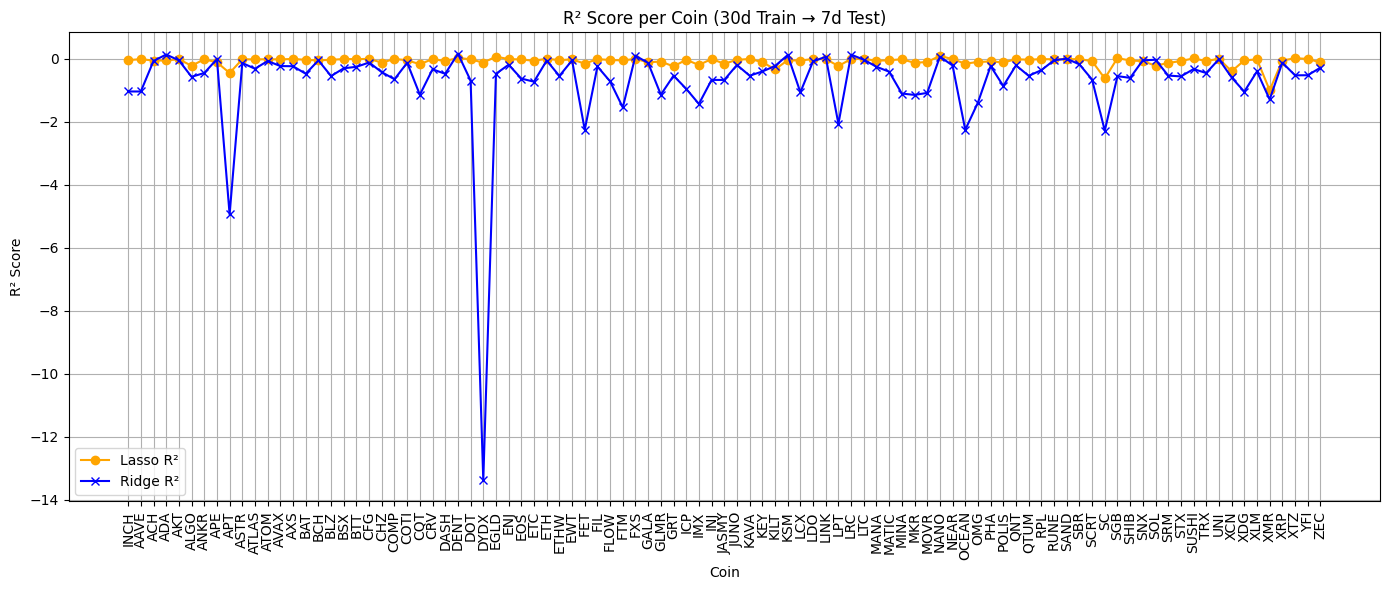

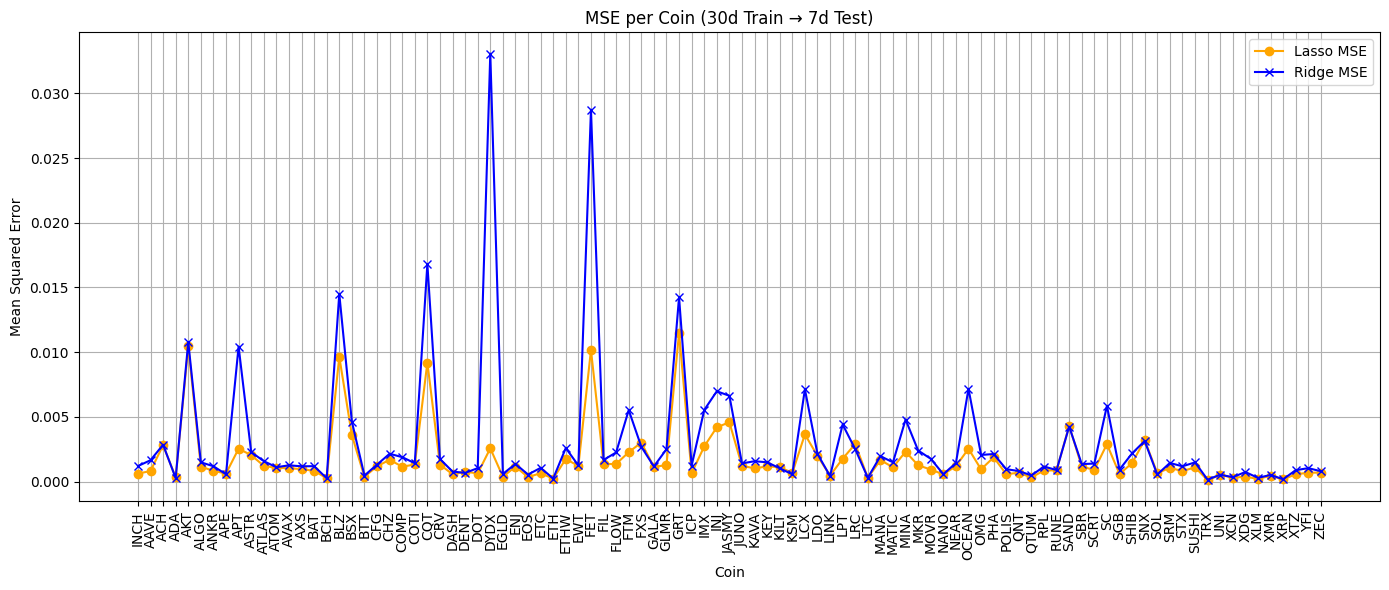

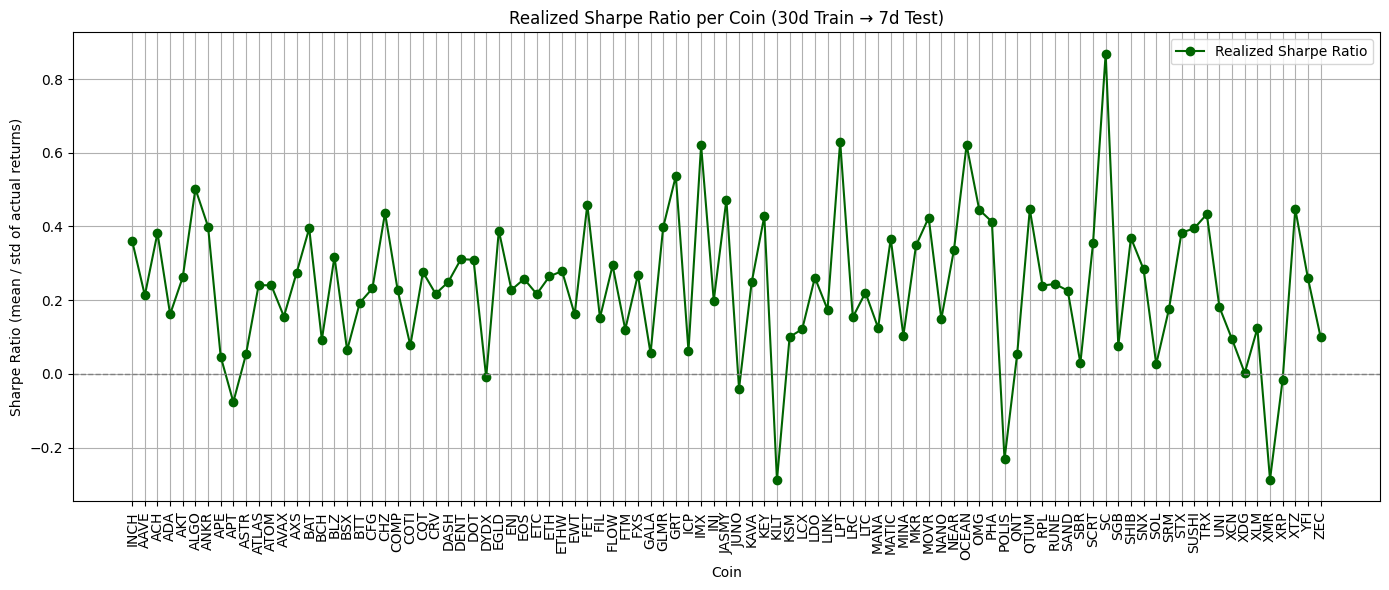

In [43]:
"""
Title: Visual Summary of Lasso and Ridge Performance Across Coins

Description:
This script generates diagnostic plots to evaluate and compare the performance of 
Lasso and Ridge regression models across multiple cryptocurrency assets.

Using results from the file `lasso_ridge_results_[train]d_[test]d.csv`, it produces:

1. R² Score Plot:
   - Visualizes the R² values for both Lasso and Ridge models, sorted by Lasso R².
   - Helps assess model fit quality per coin.

2. MSE Plot:
   - Compares Mean Squared Errors of Lasso and Ridge for each coin.
   - Coins are sorted by Lasso MSE for clarity.

3. Sharpe Ratio Plot:
   - Plots realized Sharpe ratios (mean / std of actual test returns).
   - Useful to evaluate risk-adjusted return potential by coin.
   - Includes a horizontal line at Sharpe = 0 to distinguish profitable vs. unprofitable coins.

All plots are labeled by coin and annotated with the training and test window durations
(`train_period_days` → `pred_period_days`), making this visualization easily reusable
across different time horizon configurations.

Make sure `results_csv` and the associated `train_period_days` and `pred_period_days` 
variables are set correctly before running this script.
"""

# === Extract clean coin names and drop NaNs ===
df_results = df_results.copy()
df_results["coin_clean"] = df_results["coin"].str.extract(r'([A-Z]+)USD', expand=False)
df_results = df_results.dropna(subset=["coin_clean"])

# === Plot Lasso and Ridge R² vs. Coins ===
plt.figure(figsize=(14, 6))
plt.plot(df_results['coin_clean'], df_results['r2_lasso'], label="Lasso R²", marker='o', color='orange')
plt.plot(df_results['coin_clean'], df_results['r2_ridge'], label="Ridge R²", marker='x', color='blue')
plt.title(f"R² Score per Coin ({train_period_days}d Train → {pred_period_days}d Test)")
plt.xlabel("Coin")
plt.ylabel("R² Score")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"r2_per_coin_{train_period_days}d_{pred_period_days}d.png")
plt.show()

# === Plot MSE per Coin ===
plt.figure(figsize=(14, 6))
plt.plot(df_results['coin_clean'], df_results['mse_lasso'], label="Lasso MSE", marker='o', color='orange')
plt.plot(df_results['coin_clean'], df_results['mse_ridge'], label="Ridge MSE", marker='x', color='blue')
plt.title(f"MSE per Coin ({train_period_days}d Train → {pred_period_days}d Test)")
plt.xlabel("Coin")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"mse_per_coin_{train_period_days}d_{pred_period_days}d.png")
plt.show()

# === Plot Sharpe Ratio per Coin ===
plt.figure(figsize=(14, 6))
plt.plot(df_results['coin_clean'], df_results['realized_sharpe'], label="Realized Sharpe Ratio", marker='o', color='darkgreen')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title(f"Realized Sharpe Ratio per Coin ({train_period_days}d Train → {pred_period_days}d Test)")
plt.xlabel("Coin")
plt.ylabel("Sharpe Ratio (mean / std of actual returns)")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"sharpe_ratio_per_coin_{train_period_days}d_{pred_period_days}d.png")
plt.show()

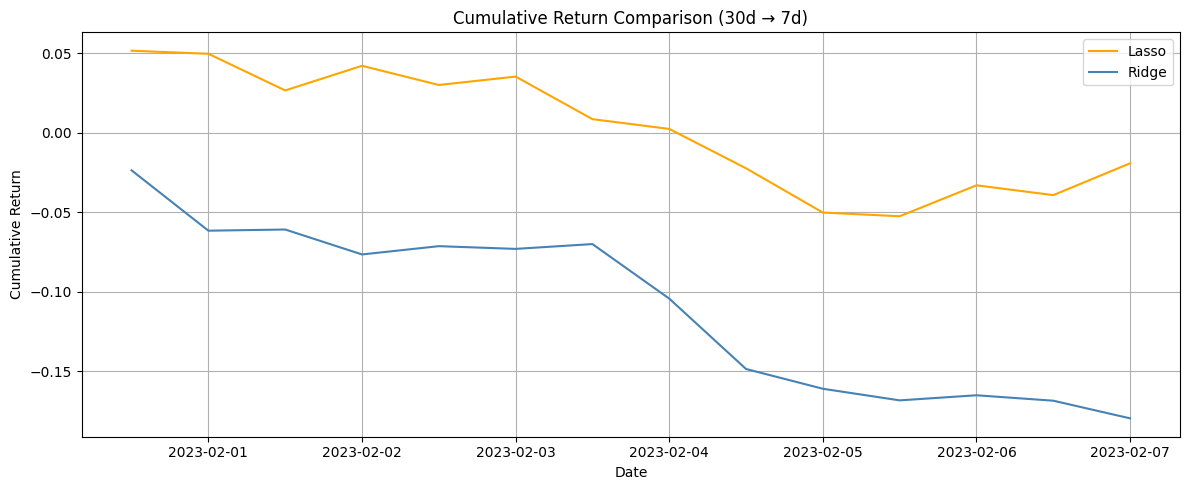


Sharpe Ratio (Lasso): -5.75
Sharpe Ratio (Ridge): -73.51


In [38]:
"""
Title: Dual Model Long-Short Strategy Backtest: Lasso vs Ridge

Description:
This script compares the performance of Lasso and Ridge regression models 
in forecasting cryptocurrency log returns through a long-short portfolio strategy.

Workflow:
1. Loads cached Lasso and Ridge models (from `lasso_models` and `ridge_models` dictionaries),
   which include the trained model, scaler, and feature set for each coin.
2. For each filtered coin:
   - Loads and preprocesses test data (matching train/test split from earlier pipeline stages)
   - Uses the stored models to generate out-of-sample return predictions
3. Constructs a long-short portfolio strategy for each model:
   - At each test timestamp, selects the top and bottom deciles of coins based on predicted returns
   - Computes realized long-short return and accumulates performance
4. Plots cumulative returns of both models on the same graph.
5. Calculates and prints the annualized Sharpe ratio for Lasso and Ridge strategies.

Inputs:
- `df_results["coin"]`: filtered coins based on Sharpe ratio
- `lasso_models` and `ridge_models`: pre-trained model caches
- `datasets_2023-2025_beta.parquet`: raw feature and return data

Outputs:
- Matplotlib plot comparing cumulative return trajectories for Lasso and Ridge
- Printed Sharpe ratios for each model's portfolio

Note:
Ensure the model caches were trained using the same window configuration (train/test split)
and stored in the form: `{coin: (model, scaler, feature_list)}`
"""

# === Predict and backtest for both models ===
def generate_predictions(models_dict, model_label):
    all_preds = []

    for coin in coins:
        if coin not in models_dict:
            continue

        coin_df = original_df[original_df["filename"].str.contains(coin)].copy()
        coin_df = coin_df.sort_values("timestamp")
        model, scaler, features = models_dict[coin]

        coin_df = coin_df.dropna(subset=features + ['log_return'])
        coin_df['target'] = coin_df['log_return'].shift(-lookahead)
        coin_df = coin_df.dropna()

        if len(coin_df) < 100:
            continue

        start_ts = coin_df['timestamp'].min()
        train_end_ts = start_ts + train_period_days * 86400
        test_end_ts = train_end_ts + pred_period_days * 86400

        test_df = coin_df[(coin_df['timestamp'] >= train_end_ts) & (coin_df['timestamp'] < test_end_ts)]
        if len(test_df) < 10:
            continue

        X_test = test_df[features]
        y_test = test_df['target']
        ts_test = test_df['timestamp']
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)

        preds_df = pd.DataFrame({
            'timestamp': ts_test.values,
            'coin': coin,
            'actual_return': y_test.values,
            f'predicted_return_{model_label}': y_pred
        })

        all_preds.append(preds_df)

    df_all = pd.concat(all_preds).sort_values("timestamp").dropna()
    df_all["timestamp"] = pd.to_datetime(df_all["timestamp"], unit="s")
    return df_all

# === Generate predictions ===
df_lasso = generate_predictions(lasso_models, "lasso")
df_ridge = generate_predictions(ridge_models, "ridge")

# === Strategy Function ===
def backtest_strategy(df_preds, label):
    returns = []

    for ts, group in df_preds.groupby("timestamp"):
        group_sorted = group.sort_values(f"predicted_return_{label}", ascending=False)
        n = len(group_sorted)
        if n < 10:
            continue

        top_n = int(n * top_decile)
        bottom_n = int(n * bottom_decile)

        long_mean = group_sorted.iloc[:top_n]["actual_return"].mean()
        short_mean = group_sorted.iloc[-bottom_n:]["actual_return"].mean()
        long_short_return = long_mean - short_mean

        returns.append({"timestamp": ts, f"long_short_return_{label}": long_short_return})

    df_strategy = pd.DataFrame(returns).sort_values("timestamp")
    df_strategy[f'cumulative_return_{label}'] = df_strategy[f'long_short_return_{label}'].cumsum()
    return df_strategy

# === Run backtests ===
df_lasso_perf = backtest_strategy(df_lasso, "lasso")
df_ridge_perf = backtest_strategy(df_ridge, "ridge")

# === Merge and Plot ===
df_plot = pd.merge(df_lasso_perf, df_ridge_perf, on="timestamp", how="inner")

plt.figure(figsize=(12, 5))
plt.plot(df_plot['timestamp'], df_plot['cumulative_return_lasso'], label="Lasso", color='orange')
plt.plot(df_plot['timestamp'], df_plot['cumulative_return_ridge'], label="Ridge", color='steelblue')
plt.title(f"Cumulative Return Comparison ({train_period_days}d → {pred_period_days}d)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Compute Sharpe Ratios ===
def compute_sharpe(series, annualization_factor=8760):
    return (series.mean() / series.std()) * np.sqrt(annualization_factor)

sharpe_lasso = compute_sharpe(df_plot["long_short_return_lasso"])
sharpe_ridge = compute_sharpe(df_plot["long_short_return_ridge"])

print(f"\nSharpe Ratio (Lasso): {sharpe_lasso:.2f}")
print(f"Sharpe Ratio (Ridge): {sharpe_ridge:.2f}")

In [6]:
"""
Title: Summary of All Predictive Indicators Used in Crypto Forecasting

Description:
This script extracts and summarizes the 30 predictive indicators (features) used in modeling
cryptocurrency log returns via Lasso and Ridge regression. It lists the names, basic statistics,
and descriptions (if feature naming is interpretable) to give an overview of the predictor space.

Steps:
- Load the full dataset `datasets_2023-2025_beta.parquet`
- Choose one representative coin with enough data
- Identify and extract the 30 predictive features (excluding timestamp, return fields, etc.)
- Output a summary table of feature names, data types, and basic statistics (mean, std, etc.)

You can use this script to:
- Understand what features your model is using
- Perform feature diagnostics or EDA
- Optionally expand the script to include correlation plots or distributions

Requirements:
- `datasets_2023-2025_beta.parquet` must exist and be structured correctly.
"""

# === Pick a sample coin with enough data ===
sample_coin = original_df['filename'].value_counts().idxmax()
coin_df = original_df[original_df['filename'] == sample_coin].copy()

# === Exclude non-feature columns ===
exclude = ['timestamp', 'return', 'log_return', 'filename']
features = [col for col in coin_df.columns if col not in exclude]

# === Summarize features ===
summary = coin_df[features].describe().T
summary = summary[['mean', 'std', 'min', 'max']]
summary['dtype'] = coin_df[features].dtypes.astype(str)

# === Output ===
print(f"\nSummary of {len(features)} Predictive Features from: {sample_coin}")
print(summary)

# === Save to CSV (optional) ===
summary.to_csv(f"predictor_summary_{len(features)}_features.csv")
print(f"\nSaved feature summary to predictor_summary_{len(features)}_features.csv")


Summary of 29 Predictive Features from: 1INCHUSD_720.parquet
                             mean            std           min           max  \
open                     0.390358       0.107068  2.230000e-01  6.860000e-01   
high                     0.398843       0.110556  2.280000e-01  7.400000e-01   
low                      0.380575       0.103333  2.020000e-01  6.600000e-01   
close                    0.390265       0.106946  2.230000e-01  6.890000e-01   
volume               81441.905291  163502.241892  1.201556e+02  3.278869e+06   
trades                 116.380301     172.217558  3.000000e+00  3.669000e+03   
volume_change            1.986208      11.306325 -9.941150e-01  3.381610e+02   
close_to_high            0.979612       0.023076  7.504244e-01  1.000000e+00   
close_to_low             1.025120       0.027874  1.000000e+00  1.268657e+00   
log_price_range          0.045350       0.037224  2.436055e-03  3.627725e-01   
ma_zscore_14             0.048667       1.266674 -3.299382

In [10]:
# === Final Comparison Table for Export ===
summary_df = df_results[[
    "coin", "r2_lasso", "r2_ridge", "mse_lasso", "mse_ridge", "realized_sharpe"
]]

# Save to CSV for reporting or further analysis
summary_df.to_csv(f"model_comparison_table_{train_period_days}d_{pred_period_days}d.csv", index=False)
print(f"\nSaved model comparison table to model_comparison_table_{train_period_days}d_{pred_period_days}d.csv")


Saved model comparison table to model_comparison_table_30d_7d.csv


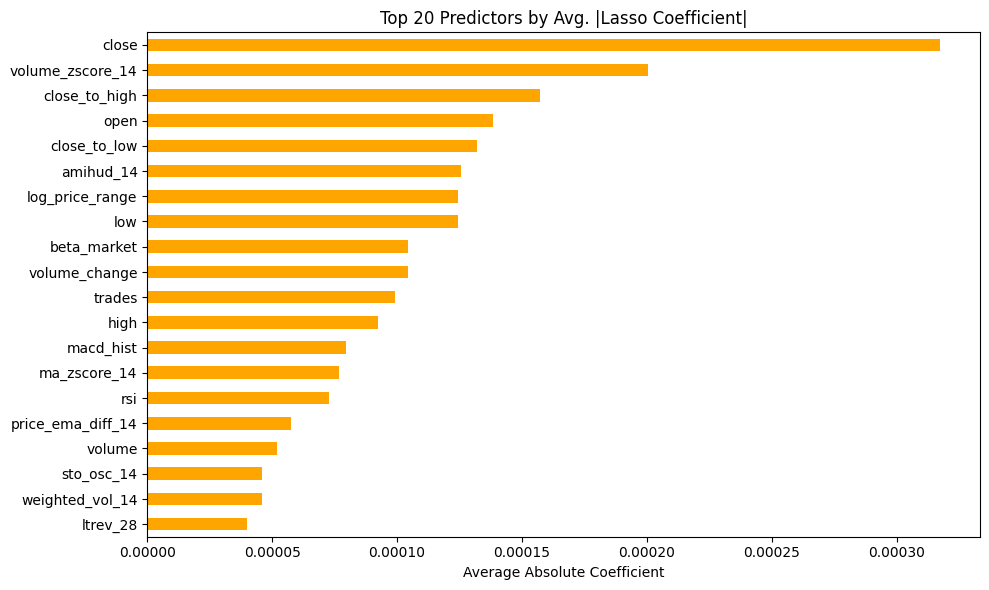

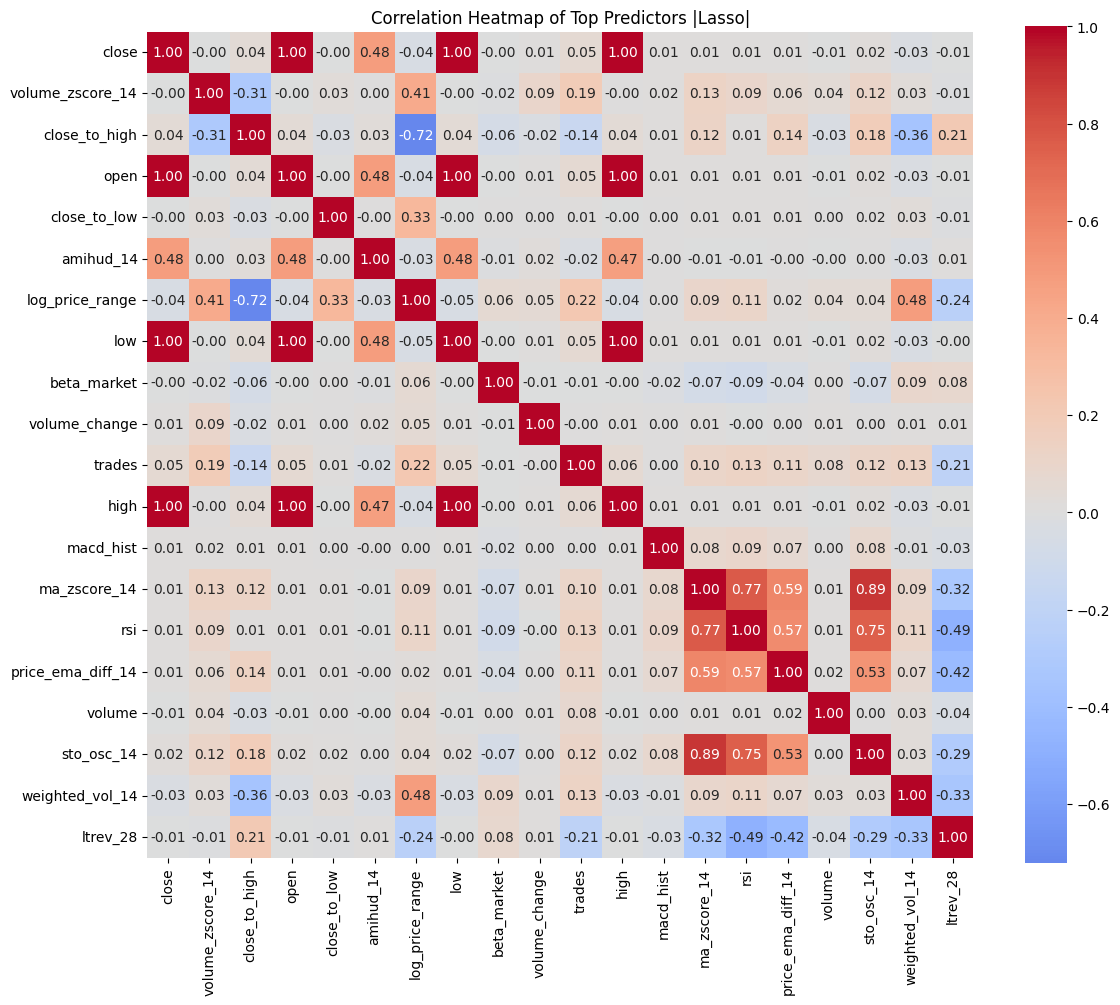

In [26]:
"""
Title: Lasso Regression Predictor Analysis and Feature Correlation Heatmap

Description:
This script analyzes the most influential predictive features from cached Lasso regression models 
across Sharpe-filtered cryptocurrency datasets. It computes the average absolute value of each 
feature's coefficient across all selected coins and identifies the top contributors. Then, it 
visualizes the correlation structure among these top features.

For each filtered coin:
- Extract the LassoCV model, scaler, and features from `lasso_models`
- Record the absolute coefficient values for each feature
- Average coefficients across coins to identify the most influential predictors

The script outputs:
- A horizontal bar chart of the top 20 features ranked by average absolute Lasso coefficient
- A heatmap of pairwise Pearson correlations between those top predictors
"""

# === Coefficient aggregation ===
feature_importance = []

for coin in df_results["coin"]:  # <-- FIXED: pull coins from df_results
    if coin not in lasso_models:
        continue

    model, scaler, features = lasso_models[coin]
    coefs = model.coef_

    feature_importance.append(pd.Series(coefs, index=features))

# === Compute average |coefficients| and rank ===
coef_df = pd.concat(feature_importance, axis=1).T
mean_abs_coef = coef_df.abs().mean().sort_values(ascending=False)
top_features = mean_abs_coef.head(top_k)

# === Plot top Lasso predictors ===
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='orange')
plt.title("Top 20 Predictors by Avg. |Lasso Coefficient|")
plt.xlabel("Average Absolute Coefficient")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# === Correlation Heatmap of Top Predictors ===
top_feature_names = top_features.index.tolist()
feature_data_all = []

for coin in df_results["coin"]:
    coin_df = original_df[original_df["filename"].str.contains(coin)].copy()
    coin_df = coin_df.sort_values("timestamp")
    coin_df = coin_df.dropna(subset=top_feature_names)

    if len(coin_df) < 100:
        continue

    feature_data_all.append(coin_df[top_feature_names])

combined_df = pd.concat(feature_data_all)
corr_matrix = combined_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Top Predictors |Lasso|")
plt.tight_layout()
plt.show()

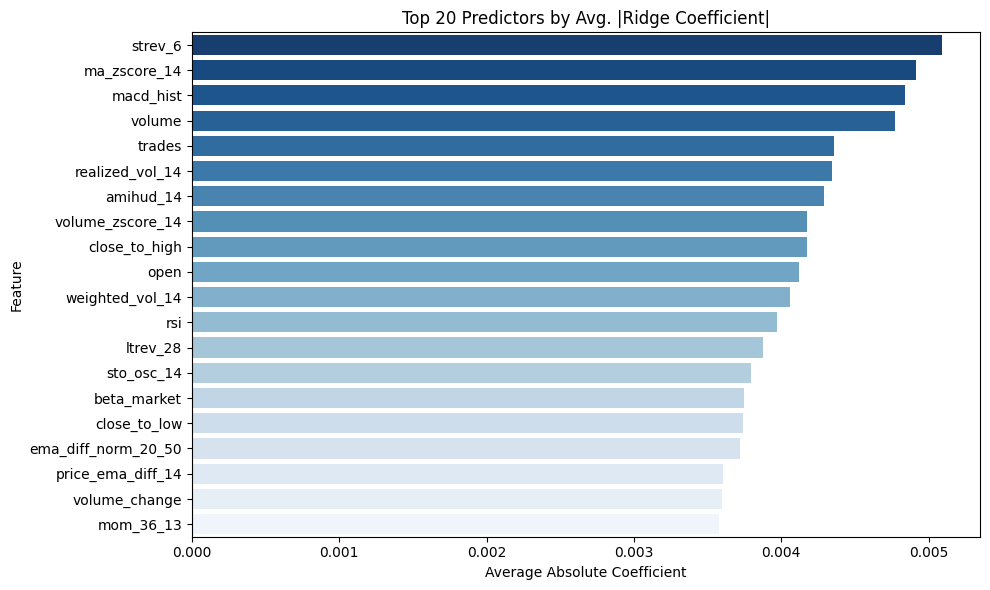

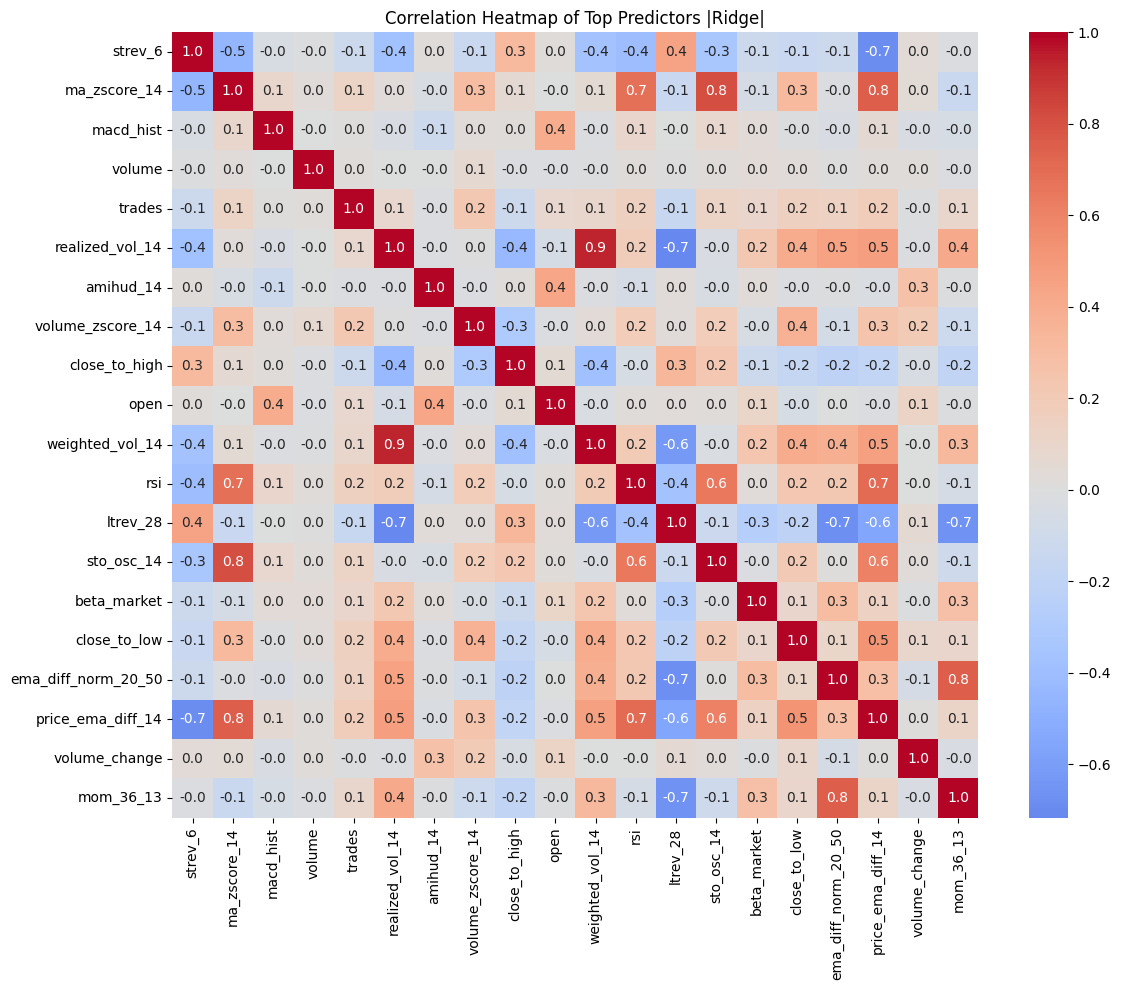

In [27]:
"""
Title: Ridge Regression Predictor Analysis and Feature Correlation Heatmap

Description:
This script analyzes the most influential predictors used by Ridge regression models 
from the pre-trained cache (`ridge_models`) across Sharpe-filtered cryptocurrency coins.
It computes the average absolute Ridge coefficients and visualizes the strongest predictors. 
It also generates a heatmap of correlations between these predictors across all coins.

Outputs:
- Bar plot of top Ridge predictors by average absolute coefficient.
- Correlation heatmap across top predictors (aggregated across coins).

Inputs:
- `ridge_models`: dictionary with structure {coin: (model, scaler, feature_list)}
- `df_results["coin"]`: list of Sharpe-filtered coin names
- `datasets_2023-2025_beta.parquet`: main features and returns dataset

Dependencies:
Ensure `pyarrow` or `fastparquet` is installed to read `.parquet` files.
"""

# === Store coefficients and feature data ===
coef_list = []
feature_data_all = []

for coin in coins:
    if coin not in ridge_models:
        continue

    model, scaler, features = ridge_models[coin]
    coin_df = original_df[original_df["filename"].str.contains(coin)].copy()
    coin_df = coin_df.sort_values("timestamp")

    coin_df = coin_df.dropna(subset=features + ['log_return'])
    coin_df['target'] = coin_df['log_return'].shift(-lookahead)
    coin_df = coin_df.dropna()

    if len(coin_df) < 100:
        continue

    # Only need training portion used for model fitting
    start_ts = coin_df['timestamp'].min()
    train_end_ts = start_ts + train_period_days * 86400
    train_df = coin_df[(coin_df['timestamp'] >= start_ts) & (coin_df['timestamp'] < train_end_ts)]
    if len(train_df) < 50:
        continue

    X_train = train_df[features]
    X_scaled = scaler.transform(X_train)

    coef_list.append(np.abs(model.coef_))
    feature_data_all.append(X_train)

# === Aggregate coefficients and rank predictors ===
coef_matrix = np.vstack(coef_list)
mean_coefs = coef_matrix.mean(axis=0)

coef_df = pd.DataFrame({
    'feature': features,
    'avg_abs_coef': mean_coefs
}).sort_values('avg_abs_coef', ascending=False)

# === Plot top predictors ===
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df.head(top_k),
    x='avg_abs_coef',
    y='feature',
    hue='feature',
    palette='Blues_r',
    legend=False
)
plt.title("Top 20 Predictors by Avg. |Ridge Coefficient|")
plt.xlabel("Average Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# === Correlation heatmap of top predictors ===
top_feature_names = coef_df.head(top_k)['feature'].tolist()

feature_data_filtered = []
for df in feature_data_all:
    if all(col in df.columns for col in top_feature_names):
        feature_data_filtered.append(df[top_feature_names])

combined_data = pd.concat(feature_data_filtered).dropna()
corr = combined_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".1f")
plt.title("Correlation Heatmap of Top Predictors |Ridge|")
plt.tight_layout()
plt.show()

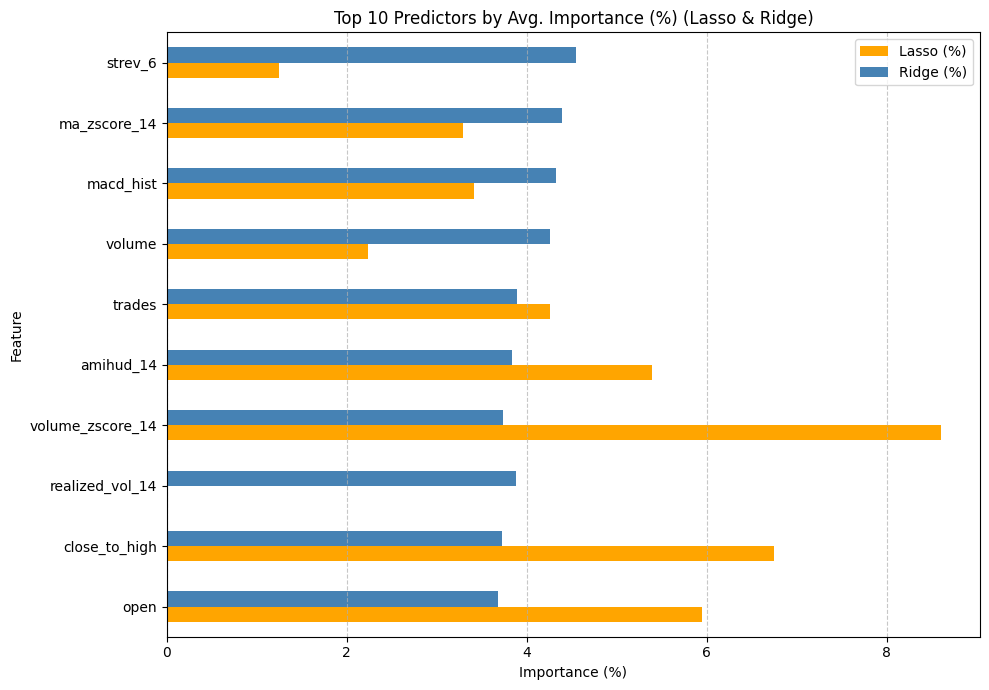

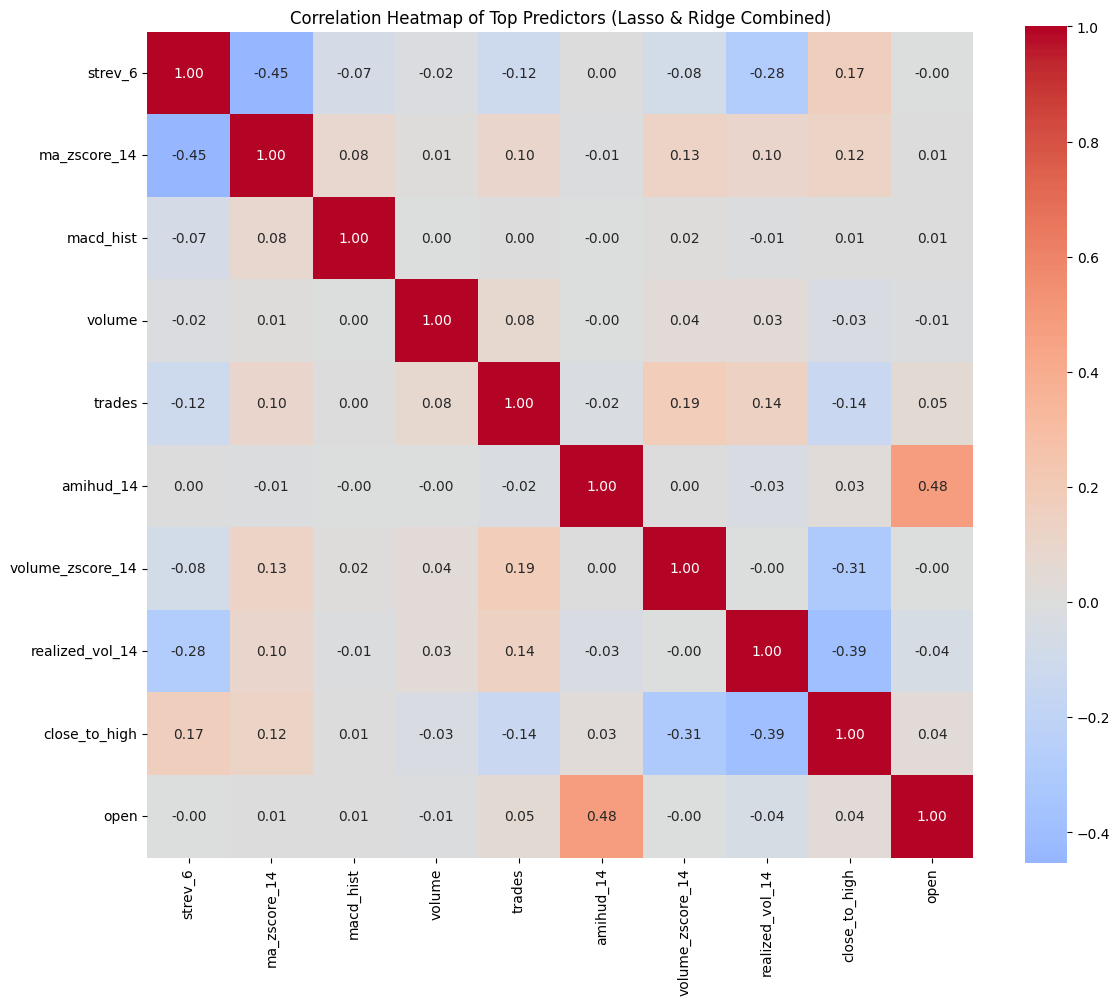

In [52]:
"""
Title: Combined Predictor Analysis for Lasso and Ridge Regression Models

Description:
This script computes and compares feature importance scores across Lasso and Ridge regression
for Sharpe-filtered cryptocurrency datasets. It identifies top predictors based on a combined
normalized weight score from both models and visualizes the result using a horizontal bar chart 
and a correlation heatmap.

Steps:
- For each coin, retrieve both Lasso and Ridge regressions from pre-trained cache.
- Normalize absolute coefficients per model to [0,1] within each coin.
- Average normalized importances across coins.
- Compute a combined importance score = 0.5*(lasso_norm + ridge_norm)
- Plot the top 20 features using side-by-side bars.
- Show a heatmap of pairwise correlations for those features.

Input:
- Parquet dataset: 'datasets_2023-2025_beta.parquet'
- Pre-loaded model caches: lasso_models, ridge_models
"""
top_k = 10
# === Store absolute coefficient vectors ===
lasso_coefs = []
ridge_coefs = []

for coin in coins:
    if coin not in lasso_models or coin not in ridge_models:
        continue

    lasso_model, _, features = lasso_models[coin]
    ridge_model, _, _ = ridge_models[coin]

    lasso_series = pd.Series(np.abs(lasso_model.coef_), index=features)
    ridge_series = pd.Series(np.abs(ridge_model.coef_), index=features)

    lasso_coefs.append(lasso_series)
    ridge_coefs.append(ridge_series)

# === Create coefficient DataFrames ===
lasso_df = pd.concat(lasso_coefs, axis=1).T
ridge_df = pd.concat(ridge_coefs, axis=1).T

# === Compute average absolute importance across coins ===
lasso_mean = lasso_df.mean()
ridge_mean = ridge_df.mean()
combined_score = 0.5 * (lasso_mean + ridge_mean)

# === Convert to percentages ===
lasso_pct = 100 * lasso_mean / lasso_mean.sum()
ridge_pct = 100 * ridge_mean / ridge_mean.sum()
combined_pct = 100 * combined_score / combined_score.sum()

# === Rank and select top predictors ===
top_features = combined_pct.sort_values(ascending=False).head(top_k).index
comparison_df = pd.DataFrame({
    "Lasso (%)": lasso_pct[top_features],
    "Ridge (%)": ridge_pct[top_features],
    "Combined (%)": combined_pct[top_features]
}).sort_values("Combined (%)", ascending=True)

# === Bar chart: Lasso vs Ridge (percentage scale) ===
comparison_df[["Lasso (%)", "Ridge (%)"]].plot(kind="barh", figsize=(10, 7),
                                               color=["orange", "steelblue"])
plt.title(f"Top {top_k} Predictors by Avg. Importance (%) (Lasso & Ridge)")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("combined_feature_importance_top10.png")
plt.show()

# === Correlation heatmap of top predictors ===
feature_data_all = []

for coin in coins:
    coin_df = original_df[original_df["filename"].str.contains(coin)].copy()
    coin_df = coin_df.sort_values("timestamp")
    coin_df = coin_df.dropna(subset=top_features)

    if len(coin_df) < 100:
        continue

    feature_data_all.append(coin_df[top_features])

combined_df = pd.concat(feature_data_all)
corr_matrix = combined_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Top Predictors (Lasso & Ridge Combined)")
plt.tight_layout()
plt.savefig("top_feature_correlation_heatmap.png")
plt.show()

In [12]:
# === Top Feature Sets from Each Model ===
top_features_lasso = lasso_mean.sort_values(ascending=False).head(top_k).index.tolist()
top_features_ridge = ridge_mean.sort_values(ascending=False).head(top_k).index.tolist()
top_features_combined = top_features.tolist()

# === Compute Overlaps ===
overlap_lasso_ridge = sorted(set(top_features_lasso) & set(top_features_ridge))
overlap_all = sorted(set(top_features_lasso) & set(top_features_ridge) & set(top_features_combined))

# === Print Overlap Summary ===
print("\n--- Feature Overlap Summary ---")
print(f"Top {top_k} features per model:")
print(f"- Lasso only: {len(top_features_lasso)}")
print(f"- Ridge only: {len(top_features_ridge)}")
print(f"- Combined score: {len(top_features_combined)}")
print(f"→ Overlap (Lasso ∩ Ridge): {len(overlap_lasso_ridge)} features")
print(f"→ Overlap (All 3): {len(overlap_all)} features")
print(f"\nFeatures in All Three:\n{overlap_all}")

# === Save to CSV ===
overlap_df = pd.DataFrame({
    "Lasso_Top": pd.Series(top_features_lasso),
    "Ridge_Top": pd.Series(top_features_ridge),
    "Combined_Top": pd.Series(top_features_combined)
})
overlap_df.to_csv(f"feature_overlap_lasso_ridge_combined_top{top_k}.csv", index=False)
print(f"\nSaved feature overlap table to 'feature_overlap_lasso_ridge_combined_top{top_k}.csv'")


--- Feature Overlap Summary ---
Top 20 features per model:
- Lasso only: 20
- Ridge only: 20
- Combined score: 20
→ Overlap (Lasso ∩ Ridge): 15 features
→ Overlap (All 3): 15 features

Features in All Three:
['amihud_14', 'beta_market', 'close', 'close_to_high', 'low', 'ma_zscore_14', 'macd_hist', 'mom_36_13', 'rsi', 'sto_osc_14', 'trades', 'volume', 'volume_change', 'volume_zscore_14', 'weighted_vol_14']

Saved feature overlap table to 'feature_overlap_lasso_ridge_combined_top20.csv'


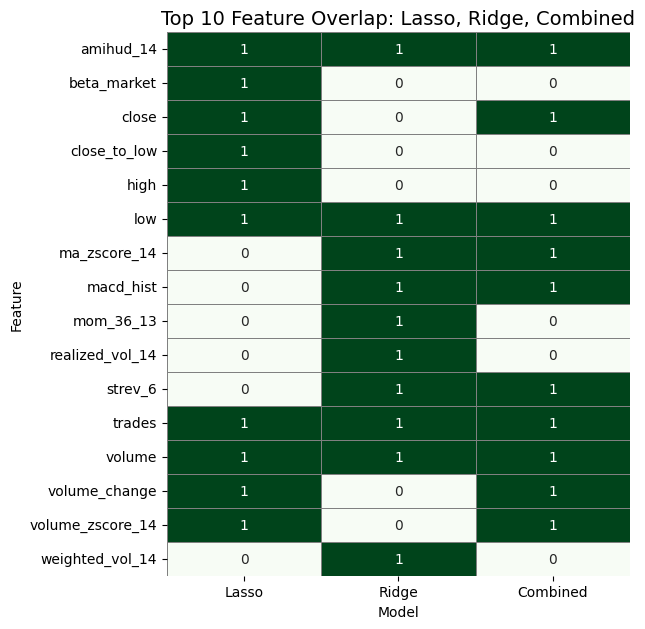

In [48]:
"""
Title: Feature Overlap Heatmap — Lasso, Ridge, Combined

Description:
This script visualizes the overlap of top-k predictive features selected by Lasso, Ridge, 
and a Combined score (average of the two). It builds a binary heatmap showing whether each 
feature is selected by each model's top-k ranking.

Inputs:
- `lasso_mean`, `ridge_mean`, and `combined_score`: Normalized average coefficients.
- `top_k`: Number of top features to consider.

Output:
- A heatmap showing which model(s) selected each feature.
"""
# === Config ===
top_k = 10  # Reduced from 20 to 10
output_path = "feature_overlap_heatmap_top10.png"

# === Top features per model ===
top_lasso = set(lasso_mean.sort_values(ascending=False).head(top_k).index)
top_ridge = set(ridge_mean.sort_values(ascending=False).head(top_k).index)
top_combined = set(combined_score.sort_values(ascending=False).head(top_k).index)

# === Union of all top features ===
all_top_features = sorted(top_lasso.union(top_ridge).union(top_combined))

# === Build binary presence matrix ===
overlap_df = pd.DataFrame(index=all_top_features)
overlap_df["Lasso"] = overlap_df.index.isin(top_lasso).astype(int)
overlap_df["Ridge"] = overlap_df.index.isin(top_ridge).astype(int)
overlap_df["Combined"] = overlap_df.index.isin(top_combined).astype(int)

# === Plot heatmap ===
plt.figure(figsize=(6.5, len(overlap_df) * 0.4))
sns.heatmap(overlap_df, cmap="Greens", annot=True, cbar=False, linewidths=0.5,
            linecolor="gray", fmt="d")
plt.title(f"Top {top_k} Feature Overlap: Lasso, Ridge, Combined", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(output_path)
plt.show()